In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
import sys
sys.path.append("../")
import functions as f
plt.style.use('seaborn-v0_8-whitegrid')
#plt.style.available
import seaborn as sns
import load_data as ld
import classes as cl
from sklearn import datasets
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Own code classification

In [2]:

# Prepare the dataset
data = pd.read_csv('../../data/Wisconsin.csv')

# Select features and target (radius_mean and texture_mean, diagnosis)
X = data[['radius_mean', 'texture_mean']].values
y = data['diagnosis'].apply(lambda x: 1 if x == 'M' else 0).values.reshape(-1, 1)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)


# Standardize the data. It does not make sense to standardize/scale the y values because they are binary.
X_train, X_test = f.scale_train_test(X_train, X_test)

# Set layer sizes: 2 (input), 16 (hidden), 8 (hidden), 1 (output)
input_size = 2
layer_sizes = [12, 12, 1]

activation_funcs = [f.ReLU, f.ReLU, f.sigmoid]

# Define learning rates and epochs to test
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
epochs_list = [900, 925, 950, 975, 1000]

# Initialize an array to store accuracy values
accuracy_array = np.zeros((len(learning_rates), len(epochs_list)))

for j, epoch in enumerate(epochs_list):
    for i, lr in enumerate(learning_rates):
        # Initialize layers and activation functions
        layers = f.create_layers_batch(input_size, layer_sizes)
        
        # Train the neural network
        trained_layers = f.train_network(X_train, y_train, layers, activation_funcs, f.cost_bce, lr, epoch)
    
        # Predict on test data
        y_pred = f.feed_forward_batch(X_test, trained_layers, activation_funcs)
        y_pred_classes = (y_pred > 0.5).astype(int)
    
        # Calculate accuracy
        accuracy = np.mean(y_pred_classes == y_test)
        print(f"Learning Rate: {lr}, Epochs: {epoch}, Accuracy: {accuracy:.4f}")
    
        # Store the accuracy in the array
        accuracy_array[i, j] = accuracy

Layer 0: W shape = (12, 2), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Epoch 0: Layer shapes:
Layer 0: W shape = (12, 2), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 2), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 2), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 2), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 2), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 2), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 2), b shape = (12,)
Layer 1: 

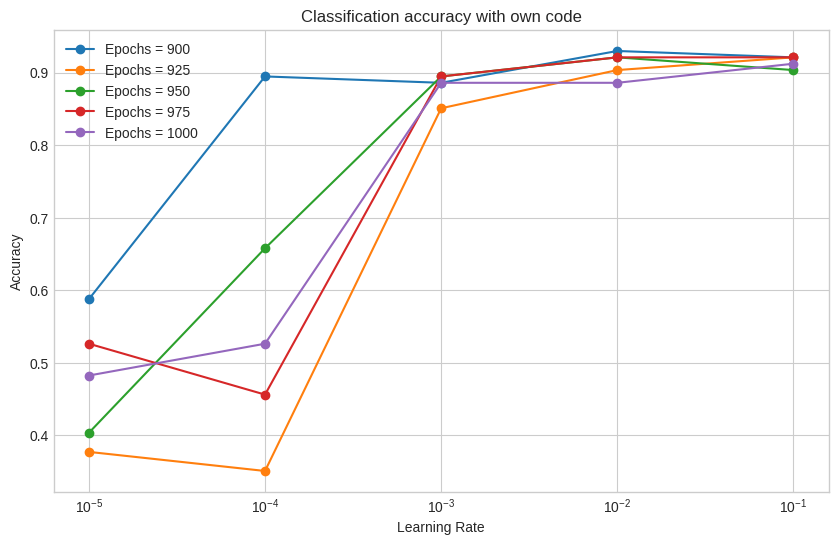

In [3]:
f.plot_accuracy_vs_learning_rate(accuracy_array, learning_rates, epochs_list, "Classification accuracy with own code")

## Pytorch code classification

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd


X, y = ld.load_wisconsin_data()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Set model parameters
input_size = X_train.shape[1]
hidden_size1 = 12
hidden_size2 = 12
output_size = 1

learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
epochs_list = [900, 925, 950, 975, 1000]

# Initialize an array to store accuracy values
accuracy_array = np.zeros((len(learning_rates), len(epochs_list)))

for j, num_epochs in enumerate(epochs_list):
    for i, lr in enumerate(learning_rates):
        # Initialize the model with specified activation functions
        model = cl.RegClasNN(
            input_size, hidden_size1, hidden_size2, output_size,
            activation_function=nn.ReLU(),
            last_layer_activation=nn.Sigmoid()
        )
        criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train the model
        for epoch in range(num_epochs):
            model.train()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Optionally, print loss every 100 epochs
            # if (epoch+1) % 100 == 0:
            #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test)
            y_pred_classes = (y_pred > 0.5).float()

        # Convert to numpy arrays and flatten
        y_test_np = y_test.numpy().flatten()
        y_pred_classes_np = y_pred_classes.numpy().flatten()

        # Calculate accuracy
        accuracy = accuracy_score(y_test_np, y_pred_classes_np)
        print(f"Learning Rate: {lr}, Epochs: {num_epochs}, Accuracy: {accuracy:.4f}")

        # Store the accuracy in the array
        accuracy_array[i, j] = accuracy



Learning Rate: 1e-05, Epochs: 900, Accuracy: 0.4035
Learning Rate: 0.0001, Epochs: 900, Accuracy: 0.8684
Learning Rate: 0.001, Epochs: 900, Accuracy: 0.9035
Learning Rate: 0.01, Epochs: 900, Accuracy: 0.9035
Learning Rate: 0.1, Epochs: 900, Accuracy: 0.9123
Learning Rate: 1e-05, Epochs: 925, Accuracy: 0.4035
Learning Rate: 0.0001, Epochs: 925, Accuracy: 0.8333
Learning Rate: 0.001, Epochs: 925, Accuracy: 0.9123
Learning Rate: 0.01, Epochs: 925, Accuracy: 0.9298
Learning Rate: 0.1, Epochs: 925, Accuracy: 0.8947
Learning Rate: 1e-05, Epochs: 950, Accuracy: 0.5965
Learning Rate: 0.0001, Epochs: 950, Accuracy: 0.8421
Learning Rate: 0.001, Epochs: 950, Accuracy: 0.9123
Learning Rate: 0.01, Epochs: 950, Accuracy: 0.9298
Learning Rate: 0.1, Epochs: 950, Accuracy: 0.9298
Learning Rate: 1e-05, Epochs: 975, Accuracy: 0.5088
Learning Rate: 0.0001, Epochs: 975, Accuracy: 0.8596
Learning Rate: 0.001, Epochs: 975, Accuracy: 0.9211
Learning Rate: 0.01, Epochs: 975, Accuracy: 0.9211
Learning Rate: 0.1

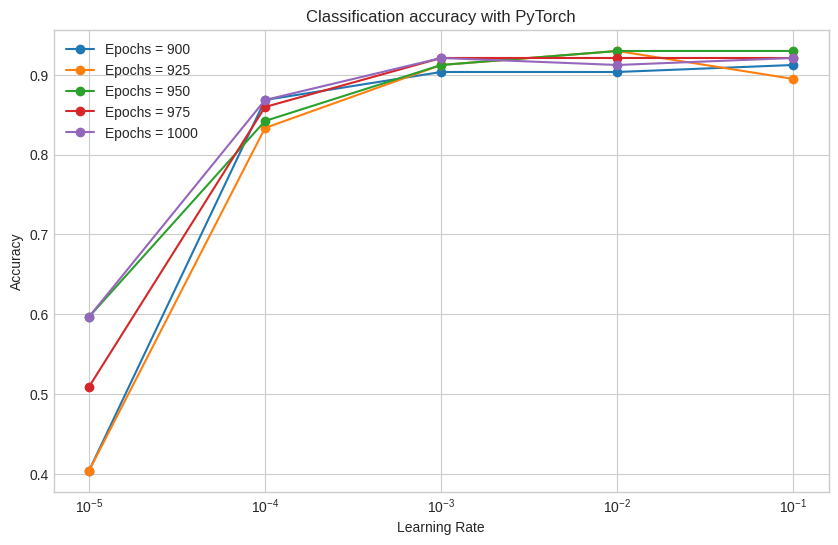

In [5]:
f.plot_accuracy_vs_learning_rate(accuracy_array, learning_rates, epochs_list, "Classification accuracy with PyTorch")